# GNO vs MGN (based on UAI1_full_resolution.py)


In [1]:
!nvidia-smi

Tue Oct 17 21:44:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:C7:00.0 Off |                    0 |
| N/A   30C    P0              53W / 400W |      4MiB / 40960MiB |      0%   E. Process |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import numpy as np
import os
import torch.nn.functional as F
from tqdm import trange
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
from utilities import *
from nn_conv import NNConv_old

from timeit import default_timer

# Preprocessing the Dataset

GNO involves constructing graphs from the simulation results. As GNO performs integration on a prescribed ball with defined radius r, the connecitivity of node pair will be found by using the functions given in utilities

In [3]:
root_dir = os.getcwd()
print(root_dir)
#dataset_dir = os.path.join(root_dir, 'datasets')

#data_dir = '/data/gpfs/Projects/CSE_HPML/GNN+flow/00_dataset'
#dataset_dir = os.path.join(root_dir, 'datasets')

TRAIN_NAME = 'piececonst_r241_N1024_smooth1.mat'
TEST_NAME = 'piececonst_r241_N1024_smooth2.mat'

dataset_dir = os.path.join(root_dir, 'datasets')
if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

train_data_path = os.path.join(dataset_dir, TRAIN_NAME)
test_data_path = os.path.join(dataset_dir, TEST_NAME)
checkpoint_dir = os.path.join(root_dir, 'best_models')
postprocess_dir = os.path.join(root_dir, 'animations')
modelsummary_dir = os.path.join(root_dir, 'model_details')

/scratch/users/ju1/01_nvidia_research/01_ccs_project/01_gno/01_test


## Input parameters

In [4]:
r = 4 # radius of the stencil
s = int(((241 - 1)/r) + 1) # number of points on the grid
n = s**2 # number of nodes in the graph
m = 100 # number of training examples
k = 1 # number of features per node

radius_train = 0.1 # radius of training data
radius_test = 0.1 # radius of test data

print('resolution', s)
print('number of nodes', n)

ntrain = 100 # number of training examples
ntest = 40  # number of test examples

batch_size = 1
batch_size2 = 2
width = 64
ker_width = 256
depth = 3
edge_features = 6
node_features = 6

epochs = 200
learning_rate = 0.0001
scheduler_step = 50
scheduler_gamma = 0.8

path = 'UAI1_r'+str(s)+'_n'+ str(ntrain)
path_model = 'model/'+path+''
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path+''
path_train_err = 'results/'+path+'train'
path_test_err16 = 'results/'+path+'test16'
path_test_err31 = 'results/'+path+'test31'
path_test_err61 = 'results/'+path+'test61'
path_image_train = 'image/'+path+'train'
path_image_test16 = 'image/'+path+'test16'
path_image_test31 = 'image/'+path+'test31'
path_image_test61 = 'image/'+path+'test61'


resolution 61
number of nodes 3721


In [5]:
## hyper-parameter
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model': 'gno',  
         'data_type': 'darcy',
         'width': width,
         'ker_width': ker_width, 
         'depth': depth,
         'batch_size': batch_size,
         'ntrain':ntrain,
         'k': k,
         'ntest':ntest,
         'batch_size2': batch_size2,
         'edge_features': edge_features,
         'node_features': node_features,
         'epochs': 200, 
         'learning_rate': 1e-4,
         'weight_decay': 5e-4,
         'scheduler_step': 50,
         'scheduler_gamma': 0.8,
         'save_best_model': True,
         'checkpoint_dir': './best_models/',
          'modelsummary_dir': './model_details/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)
    
if not os.path.isdir(args.postprocess_dir):
    os.mkdir(args.postprocess_dir)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
np.random.seed(5)     #NumPy

## Graph reconstruction (skip this if the processed dataset exists)

In [6]:

t1 = default_timer()

reader = MatReader(train_data_path)
train_a = reader.read_field('coeff')[:ntrain,::r,::r].reshape(ntrain,-1)
train_a_smooth = reader.read_field('Kcoeff')[:ntrain,::r,::r].reshape(ntrain,-1)
train_a_gradx = reader.read_field('Kcoeff_x')[:ntrain,::r,::r].reshape(ntrain,-1)
train_a_grady = reader.read_field('Kcoeff_y')[:ntrain,::r,::r].reshape(ntrain,-1)
train_u = reader.read_field('sol')[:ntrain,::r,::r].reshape(ntrain,-1)
train_u64 = reader.read_field('sol')[:ntrain,::r,::r].reshape(ntrain,-1)

reader.load_file(test_data_path)
test_a = reader.read_field('coeff')[:ntest,::4,::4].reshape(ntest,-1)
test_a_smooth = reader.read_field('Kcoeff')[:ntest,::4,::4].reshape(ntest,-1)
test_a_gradx = reader.read_field('Kcoeff_x')[:ntest,::4,::4].reshape(ntest,-1)
test_a_grady = reader.read_field('Kcoeff_y')[:ntest,::4,::4].reshape(ntest,-1)
test_u = reader.read_field('sol')[:ntest,::4,::4].reshape(ntest,-1)


a_normalizer = GaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)
as_normalizer = GaussianNormalizer(train_a_smooth)
train_a_smooth = as_normalizer.encode(train_a_smooth)
test_a_smooth = as_normalizer.encode(test_a_smooth)
agx_normalizer = GaussianNormalizer(train_a_gradx)
train_a_gradx = agx_normalizer.encode(train_a_gradx)
test_a_gradx = agx_normalizer.encode(test_a_gradx)
agy_normalizer = GaussianNormalizer(train_a_grady)
train_a_grady = agy_normalizer.encode(train_a_grady)
test_a_grady = agy_normalizer.encode(test_a_grady)


test_a = test_a.reshape(ntest,61,61)
test_a_smooth = test_a_smooth.reshape(ntest,61,61)
test_a_gradx = test_a_gradx.reshape(ntest,61,61)
test_a_grady = test_a_grady.reshape(ntest,61,61)
test_u = test_u.reshape(ntest,61,61)

test_a16 =test_a[:ntest,::4,::4].reshape(ntest,-1)
test_a_smooth16 = test_a_smooth[:ntest,::4,::4].reshape(ntest,-1)
test_a_gradx16 = test_a_gradx[:ntest,::4,::4].reshape(ntest,-1)
test_a_grady16 = test_a_grady[:ntest,::4,::4].reshape(ntest,-1)
test_u16 = test_u[:ntest,::4,::4].reshape(ntest,-1)
test_a31 =test_a[:ntest,::2,::2].reshape(ntest,-1)
test_a_smooth31 = test_a_smooth[:ntest,::2,::2].reshape(ntest,-1)
test_a_gradx31 = test_a_gradx[:ntest,::2,::2].reshape(ntest,-1)
test_a_grady31 = test_a_grady[:ntest,::2,::2].reshape(ntest,-1)
test_u31 = test_u[:ntest,::2,::2].reshape(ntest,-1)
test_a =test_a.reshape(ntest,-1)
test_a_smooth = test_a_smooth.reshape(ntest,-1)
test_a_gradx = test_a_gradx.reshape(ntest,-1)
test_a_grady = test_a_grady.reshape(ntest,-1)
test_u = test_u.reshape(ntest,-1)


u_normalizer = GaussianNormalizer(train_u)
train_u = u_normalizer.encode(train_u)
# test_u = y_normalizer.encode(test_u)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[s,s])
edge_index = meshgenerator.ball_connectivity(radius_train)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)

data_train = []
for j in range(ntrain):
    edge_attr = meshgenerator.attributes(theta=train_a[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=train_u[j,:])
    data_train.append(Data(x=torch.cat([grid, train_a[j,:].reshape(-1, 1),
                                        train_a_smooth[j,:].reshape(-1, 1), train_a_gradx[j,:].reshape(-1, 1), train_a_grady[j,:].reshape(-1, 1)
                                        ], dim=1),
                           y=train_u[j,:], coeff=train_a[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary= edge_attr_boundary
                           ))

print('train grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[16,16])
edge_index = meshgenerator.ball_connectivity(radius_test)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)
data_test16 = []
for j in range(ntest):
    edge_attr = meshgenerator.attributes(theta=test_a16[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=test_a[j, :])
    data_test16.append(Data(x=torch.cat([grid, test_a16[j,:].reshape(-1, 1),
                                       test_a_smooth16[j,:].reshape(-1, 1), test_a_gradx16[j,:].reshape(-1, 1), test_a_grady16[j,:].reshape(-1, 1)
                                       ], dim=1),
                           y=test_u16[j, :], coeff=test_a16[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary=edge_attr_boundary
                          ))

print('16 grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)
# print('edge_index_boundary', edge_index_boundary.shape, 'edge_attr', edge_attr_boundary.shape)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[31,31])
edge_index = meshgenerator.ball_connectivity(radius_test)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)
data_test31 = []
for j in range(ntest):
    edge_attr = meshgenerator.attributes(theta=test_a31[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=test_a[j, :])
    data_test31.append(Data(x=torch.cat([grid, test_a31[j,:].reshape(-1, 1),
                                       test_a_smooth31[j,:].reshape(-1, 1), test_a_gradx31[j,:].reshape(-1, 1), test_a_grady31[j,:].reshape(-1, 1)
                                       ], dim=1),
                           y=test_u31[j, :], coeff=test_a31[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary=edge_attr_boundary
                          ))

print('31 grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)
# print('edge_index_boundary', edge_index_boundary.shape, 'edge_attr', edge_attr_boundary.shape)

meshgenerator = SquareMeshGenerator([[0,1],[0,1]],[61,61])
edge_index = meshgenerator.ball_connectivity(radius_test)
grid = meshgenerator.get_grid()
# meshgenerator.get_boundary()
# edge_index_boundary = meshgenerator.boundary_connectivity2d(stride = stride)
data_test61 = []
for j in range(ntest):
    edge_attr = meshgenerator.attributes(theta=test_a[j,:])
    # edge_attr_boundary = meshgenerator.attributes_boundary(theta=test_a[j, :])
    data_test61.append(Data(x=torch.cat([grid, test_a[j,:].reshape(-1, 1),
                                       test_a_smooth[j,:].reshape(-1, 1), test_a_gradx[j,:].reshape(-1, 1), test_a_grady[j,:].reshape(-1, 1)
                                       ], dim=1),
                           y=test_u[j, :], coeff=test_a[j,:],
                           edge_index=edge_index, edge_attr=edge_attr,
                           # edge_index_boundary=edge_index_boundary, edge_attr_boundary=edge_attr_boundary
                          ))

print('61 grid', grid.shape, 'edge_index', edge_index.shape, 'edge_attr', edge_attr.shape)
# print('edge_index_boundary', edge_index_boundary.shape, 'edge_attr', edge_attr_boundary.shape)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader16 = DataLoader(data_test16, batch_size=batch_size2, shuffle=False)
test_loader31 = DataLoader(data_test31, batch_size=batch_size2, shuffle=False)
test_loader61 = DataLoader(data_test61, batch_size=batch_size2, shuffle=False)



train grid torch.Size([3721, 2]) edge_index torch.Size([2, 376492]) edge_attr torch.Size([376492, 6])
16 grid torch.Size([256, 2]) edge_index torch.Size([2, 2116]) edge_attr torch.Size([2116, 6])
31 grid torch.Size([961, 2]) edge_index torch.Size([2, 22967]) edge_attr torch.Size([22967, 6])
61 grid torch.Size([3721, 2]) edge_index torch.Size([2, 376492]) edge_attr torch.Size([376492, 6])


/home/groups/tchelepi/ju1/02_dl_modeling/00_python_env/ai_science_gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
# save the processed data to avoid re-processing
torch.save(data_train, os.path.join(dataset_dir, 'data_train.pt'))
torch.save(data_test16, os.path.join(dataset_dir, 'data_test16.pt'))
torch.save(data_test31, os.path.join(dataset_dir, 'data_test31.pt'))
torch.save(data_test61, os.path.join(dataset_dir, 'data_test61.pt'))

## Read preprocessed data

In [8]:
# Only call this cell when the preprocessing is done
file_path=os.path.join(dataset_dir, 'data_train.pt')
train_loader = DataLoader(torch.load(file_path), batch_size=batch_size, shuffle=True)
test_loader16 = DataLoader(torch.load(os.path.join(dataset_dir, 'data_test16.pt')), batch_size=batch_size2, shuffle=False)
test_loader31 = DataLoader(torch.load(os.path.join(dataset_dir, 'data_test31.pt')), batch_size=batch_size2, shuffle=False)
test_loader61 = DataLoader(torch.load(os.path.join(dataset_dir, 'data_test61.pt')), batch_size=batch_size2, shuffle=False)

print(torch.load(file_path)[:1])

[Data(x=[3721, 6], edge_index=[2, 376492], edge_attr=[376492, 6], y=[3721], coeff=[3721])]


In [22]:
train_batch = next(iter(train_loader))
test_batch16 = next(iter(test_loader16))
test_batch31 = next(iter(test_loader31))
test_batch61 = next(iter(test_loader61))

print(train_batch.x[0, :])
print(test_batch16)
print(test_batch31)
print(test_batch61)


tensor([0.0000, 0.0000, 1.0033, 1.0368, 0.0347, 0.0173])
DataBatch(x=[2560, 6], edge_index=[2, 21160], edge_attr=[21160, 6], y=[2560], coeff=[2560], batch=[2560], ptr=[11])
DataBatch(x=[9610, 6], edge_index=[2, 229670], edge_attr=[229670, 6], y=[9610], coeff=[9610], batch=[9610], ptr=[11])
DataBatch(x=[37210, 6], edge_index=[2, 3764920], edge_attr=[3764920, 6], y=[37210], coeff=[37210], batch=[37210], ptr=[11])


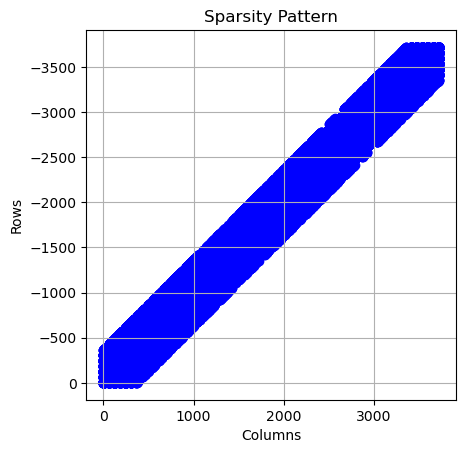

In [9]:
# inspect adjacency matrix
def edge_index_to_adjacency_matrix(edge_index, num_nodes):
    """Convert edge_index to an adjacency matrix."""
    adj_matrix = torch.zeros(num_nodes, num_nodes)
    adj_matrix[edge_index[0, :], edge_index[1, :]] = 1
    return adj_matrix

# Convert edge_index to adjacency matrix
adj_matrix = edge_index_to_adjacency_matrix(train_batch.edge_index, train_batch.x.shape[0])

# Plot adjacency matrix
x, y = np.where(adj_matrix == 1)
plt.scatter(y, -x, marker='o', color='blue')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()  # To match MATLAB's spy function's layout
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Sparsity Pattern')
plt.grid(True)
plt.show()

/tmp/ipykernel_48256/3865236868.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


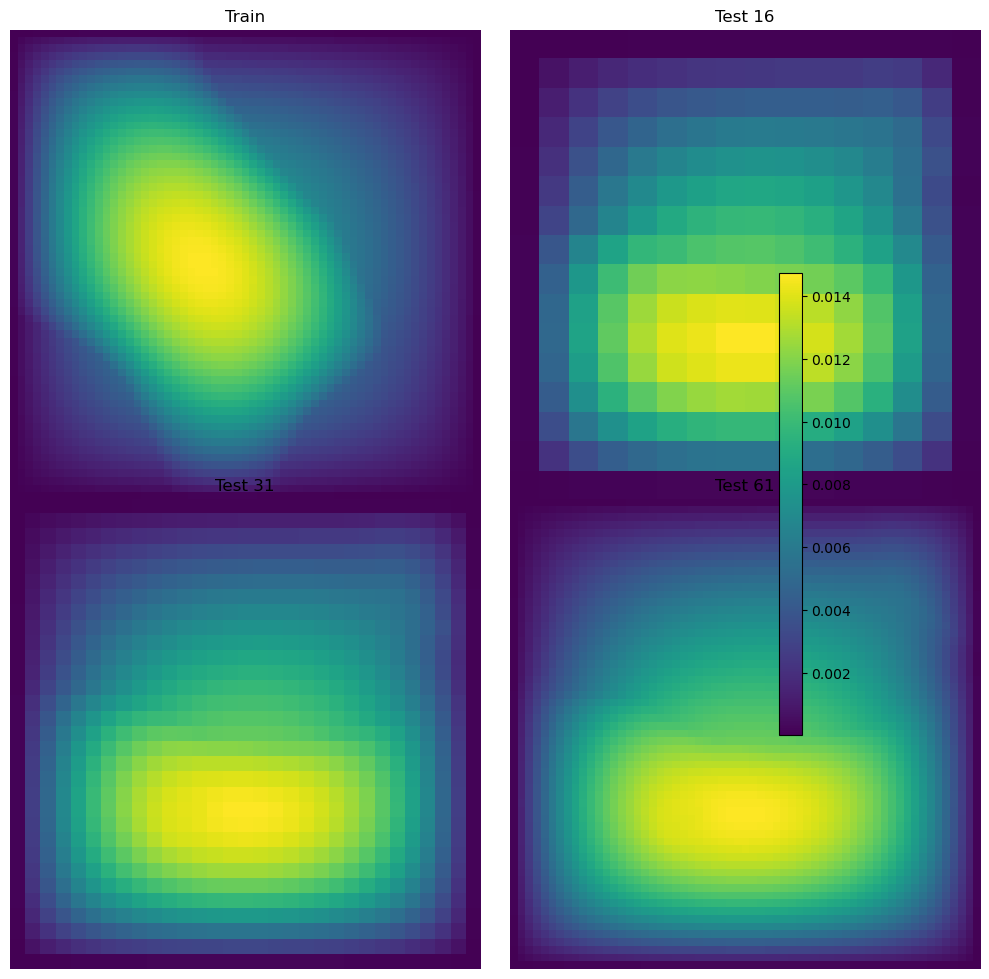

In [25]:
import matplotlib.pyplot as plt
import torch_geometric as pyg

# Extract the 'y' attributes from each batch
train_y = train_batch.y
test_y16 = test_batch16.y[0:16*16]
test_y31 = test_batch31.y[0:31*31]
test_y61 = test_batch61.y[0:61*61]

# Ensure all y attributes are in a consistent shape for plotting
# Here, I'm assuming they're 1D. If not, you might need to modify this.
resolution = 61
train_y = train_y.reshape(-1).numpy().reshape((resolution, resolution))
resolution = 16                                                 
test_y16 = test_y16.view(-1).numpy().reshape((resolution, resolution))
resolution = 31
test_y31 = test_y31.view(-1).numpy().reshape((resolution, resolution))
resolution = 61
test_y61 = test_y61.view(-1).numpy().reshape((resolution, resolution))

                                             
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plotting train y attributes
cax = axs[0, 0].imshow(train_y, cmap='viridis')
axs[0, 0].set_title('Train')
axs[0, 0].axis('off')

# Plotting test 16 y attributes
cax = axs[0, 1].imshow(test_y16, cmap='viridis')
axs[0, 1].set_title('Test 16')
axs[0, 1].axis('off')

# Plotting test 31 y attributes
cax = axs[1, 0].imshow(test_y31, cmap='viridis')
axs[1, 0].set_title('Test 31')
axs[1, 0].axis('off')

# Plotting test 61 y attributes
cax = axs[1, 1].imshow(test_y61, cmap='viridis')
axs[1, 1].set_title('Test 61')
axs[1, 1].axis('off')

# Add a colorbar for the whole figure (or you can add individually)
cbar = fig.colorbar(cax, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6)

# Tight layout to make it neat
plt.tight_layout()
# Save the figure (optional)
PATH = os.path.join(args.postprocess_dir, "y_attributes_plot.png")
plt.savefig(PATH, dpi=300)

plt.show()


# Building the Model

## Graph Neural Operator

In [8]:

class KernelNN(torch.nn.Module):
    def __init__(self, width, ker_width, depth, ker_in, in_width=1, out_width=1):
        super(KernelNN, self).__init__()
        self.depth = depth

        self.fc1 = torch.nn.Linear(in_width, width)

        kernel = DenseNet([ker_in, ker_width, ker_width, width**2], torch.nn.ReLU)
        self.conv1 = NNConv_old(width, width, kernel, aggr='mean')

        self.fc2 = torch.nn.Linear(width, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.fc1(x)
        for k in range(self.depth):
            x = F.relu(self.conv1(x, edge_index, edge_attr))

        x = self.fc2(x)
        return x

## MeshGraphNet (MGN) class

In [14]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type (node_position is encoded in edge attributes)
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )


        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension

        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)


## Temporal MGN model

In [15]:
class TransferTempoMGN(torch.nn.Module):
    def __init__(self, mgn_model, hidden_dim, output_dim, args, emb=False):
        super(TransferTempoMGN, self).__init__()
        """
        input: mgn_model: a pretrained Meshgraphnet
        """
        # initialize FeatureExtractor class, which has a complete forward function and returns
        # the last layer of processor
        self.data_type = args.data_type
        self.num_layers = args.num_layers
        
        self.need_edge_weight = args.need_edge_weight
        #self.feature_extractor = mgn_model
        self.feature_extractor = nn.ModuleList(mgn_model.children())[:-1]
        
        if (args.pre_trained):
            self.decoder = nn.ModuleList(mgn_model.children())[-1]
            for param in mgn_model.parameters():
                param.requires_grad = False
        else:
            # Fine-tuned a decoder. certainly we can the pre-trained one too
            self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )
            
        # Stack a consLSTM model after the last layer of processor is finished
        self.lstm_filter_size = args.lstm_filter_size
        self.recurrent_model = GConvLSTM(hidden_dim, hidden_dim, self.lstm_filter_size)

    def build_processor_model(self):
        return ProcessorLayer

    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge, h_0, c_0):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors

        h_0: hidden state from previous timestep
        c_0: cell state from previous timestep
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.feature_extractor[0](x) # output shape is the specified hidden dimension
        edge_attr = self.feature_extractor[1](edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x, edge_attr = self.feature_extractor[2][i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest
        # step 3: feed the propagated node embeddings into convLSTM
        if (self.need_edge_weight):
            edge_weight = edge_attr
        else:
            edge_weight = torch.ones( edge_attr.shape[0] ).to(args.device)

        h_new, c_new = self.recurrent_model(x, edge_index, edge_weight, h_0, c_0)
        # step 4: decode latent node embeddings into physical quantities of interest 

        # step 5: return hidden state and cell state
        return self.decoder(h_new), h_new, c_new

    def loss(self, pred, inputs,mean_vec_y,std_vec_y, num):
        #Define the node types that we calculate loss for

        #Get the loss mask for the nodes of the types we calculate loss for
        #Need more delibrations
        if (self.data_type.upper() == 'HEXA'):
            well_loss_mask = (torch.argmax(inputs.x[:,1:],dim=1)==torch.tensor(0)) # extra weight (well)
            normal_loss_mask = (torch.argmax(inputs.x[:,1:],dim=1)==torch.tensor(1))
        
        if (self.data_type.upper() == 'PEBI'):
            well_loss_mask = (torch.argmax(inputs.x[:,3:],dim=1)==torch.tensor(1)) # extra weight (well)
            normal_loss_mask = (torch.argmax(inputs.x[:,3:],dim=1)!=torch.tensor(1))
            
        #Normalize labels with dataset statistics
        labels = normalize(inputs.y[:, num],mean_vec_y[num],std_vec_y[num]).unsqueeze(-1)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss=torch.sqrt(torch.mean(error[normal_loss_mask])) + args.well_weight * torch.sqrt(torch.mean(error[well_loss_mask]))
        #loss=torch.sqrt(torch.mean(error))
        
        return loss

ProcessorLayer inherits from the PyG MessagePassing base class and handles processor/GNN part of the architecture. 👇

## ProcessorLayer Class: Edge Message Passing, Aggregation, and Updating


## Edge and Node MLP

In [16]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

## Save summary

In [9]:
from torchsummary import summary
def gnn_model_summary(model, args, model_name):
    
    model_params_list = list(model.named_parameters())

    # saving details
    if not os.path.isdir( args.modelsummary_dir ):
        os.mkdir(args.modelsummary_dir)

    with open( os.path.join(args.modelsummary_dir, model_name + '.txt'), 'w') as summary:
    # Record model details
        
        summary.write("----------------------------------------------------------------\n")
        line_new = "{:>20}  {:>25} {:>15}\n".format("Layer.Parameter", "Param Tensor Shape", "Param #")
        summary.write(line_new)
        summary.write("----------------------------------------------------------------\n")
        for elem in model_params_list:
            p_name = elem[0] 
            p_shape = list(elem[1].size())
            p_count = torch.tensor(elem[1].size()).prod().item()
            line_new = "{:>20}  {:>25} {:>15}\n".format(p_name, str(p_shape), str(p_count))
            summary.write(line_new)
        summary.write("----------------------------------------------------------------\n")
        total_params = sum([param.nelement() for param in model.parameters()])
        summary.write("Total params: {}\n".format(total_params))
        num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        summary.write("Trainable params: {}\n".format(num_trainable_params) )
        summary.write("Non-trainable params: {}".format(total_params - num_trainable_params))



# Training and Testing

In [10]:
import pandas as pd
import copy

## Train function

In [11]:
def train(train_loader, test_loader_list, u_normalizer, device, args, PATH=None):
    '''
    Performs a training loop on the dataset for GNO. Also calls
    test functions.
    '''
    df = pd.DataFrame(columns=['epoch','train_loss','test_loss'])
    model = KernelNN(args.width,
                     args.ker_width,
                     args.depth,
                     args.edge_features,
                     args.node_features).to(device)
    gnn_model_summary(model, args, args.model + '_depth' + str(args.depth))
    epochs = args.epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.scheduler_step, gamma=args.scheduler_gamma)
    
    myloss = LpLoss(size_average=False)
    u_normalizer.cuda()

    losses = [] # training losses
    test_losses = [] # testing losses
    best_test_loss = np.inf # initial test losses
    model.train()
    '''
    ttrain = np.zeros((epochs, ))
    ttest16 = np.zeros((epochs,))
    ttest31 = np.zeros((epochs,))
    ttest61 = np.zeros((epochs,))
    '''
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):

        train_mse = 0.0
        train_l2 = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            mse = F.mse_loss(out.view(-1, 1), batch.y.view(-1,1))
            # mse.backward()
            loss = torch.norm(out.view(-1) - batch.y.view(-1),1)
            loss.backward()

            l2 = myloss(u_normalizer.decode(out.view(args.batch_size,-1)), u_normalizer.decode(batch.y.view(args.batch_size, -1)))
            # l2.backward()
            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        t2 = default_timer()
        model.eval()
        train_loss = train_l2/(args.ntrain * args.k)
        losses.append(train_loss)
        
        #Every tenth epoch, calculate acceleration test loss
        if epoch % 10 == 0:
            test_loss_array = test(test_loader_list, args, device, model, u_normalizer, myloss)
            test_losses.append(test_loss_array) # turning a list of 3 test losses into a numpy array
            test_loss = np.sum(test_loss_array) # evaluate based on sum value
            # saving model
            if not os.path.isdir(args.checkpoint_dir):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, args.model+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)
        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            test_losses.append(test_losses[-1])
                
        print("train loss", str(round(train_loss,2)), "test loss", str(round(test_loss.item(),2)))
        pd_temp = pd.DataFrame({})
        df = df._append( {'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        
        if(epoch%100==0):
            #print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))
            if(args.save_best_model):
                PATH = os.path.join(args.checkpoint_dir, args.model + '.pt')
                torch.save(best_model.state_dict(), PATH )
                
    return losses, test_losses, best_model, best_test_loss

In [12]:
def test(test_loader_list, args, device, model, u_normalizer, myloss):
    '''
    Performs a test loop on the dataset for GNO.
    Explain input arguments:
    test_loader: test dataset
    device: GPU or CPU
    test_model: trained model
    myloss: loss function
    u_normalizer: normalizer for output
    '''
    
    u_normalizer.cuda()
    model = model.to(device)
    ntest = args.ntest
    test_res_size = len(test_loader_list)
    test_loss_array = np.zeros([test_res_size])
    batch_size2 = args.batch_size2
    with torch.no_grad():
        for i in range(3):
            test_loss = 0.0
            for batch in test_loader_list[i]:
                batch.to(device)
                out = model(batch)
                test_l2 = myloss(u_normalizer.decode(out.view(batch_size2,-1)),
                                     batch.y.view(batch_size2, -1))
                test_loss += test_l2.item()
            test_loss_array[i] = test_loss / ntest

    return test_loss_array

# Let's prepare the model for training!

Specify parameters for model training

Load the temporal dataset. Each batch contains all meshes at the same timestep

In [13]:
torch.cuda.empty_cache()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device

test_loader_list = [test_loader16, test_loader31, test_loader61]
losses, test_losses, best_model, best_test_loss = train(train_loader,
                                                          test_loader_list,
                                                          u_normalizer, 
                                                          device,
                                                          args, 
                                                          PATH=None)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

Training:   0%|▋                                                                                                                                               | 1/200 [00:57<3:11:09, 57.63s/Epochs]

train loss 0.37 test loss 0.76


Training:   1%|█▍                                                                                                                                              | 2/200 [01:47<2:55:18, 53.12s/Epochs]

train loss 0.21 test loss 0.76


Training:   2%|██▏                                                                                                                                             | 3/200 [02:37<2:49:45, 51.70s/Epochs]

train loss 0.17 test loss 0.76


Training:   2%|██▉                                                                                                                                             | 4/200 [03:27<2:46:42, 51.04s/Epochs]

train loss 0.17 test loss 0.76


Training:   2%|███▌                                                                                                                                            | 5/200 [04:17<2:44:38, 50.66s/Epochs]

train loss 0.15 test loss 0.76


Let's visualize the results!

In [40]:
def save_plots(args, losses, test_losses, velo_val_losses):
    
    #Define the model name for saving 
    model_name= args.model + '_data_'+ args.data_type + '_LSTM_k_' + str(args.lstm_filter_size )+ '_well_weight_' + str(args.well_weight) +\
                  '_norm'+ str(args.normalized)+ '_model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)
    
    if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss" + " - " + args.model)
    plt.plot(test_losses, label="test loss" + " - " + args.model)
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    f.savefig(PATH, bbox_inches='tight')

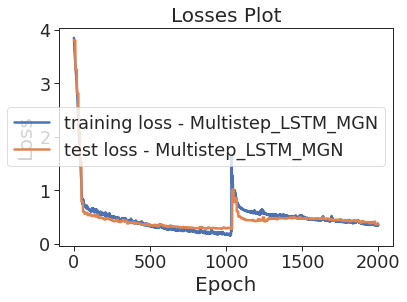

In [41]:
save_plots(args, losses, test_losses, velo_val_losses)

# Post-processing

In [136]:
from matplotlib import rc
import seaborn as sns 
import matplotlib as mpl

# set the plot style
def set_style():
    #plt.rc("font", family="Times New Roman")
    rc('mathtext', default='regular')
    sns.set_style('ticks')
    sns.set(style="ticks", rc={'axes.linewidth': 3.0, 'font.family': "sans-serif"})    
    sns.set_context("paper",font_scale = 2.0, rc={"font.size":20,
                                                  "axes.titlesize":20,
                                                  "axes.labelsize":20,
                                                  "lines.linewidth": 2.5})
     
set_style()
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

## Darcy's flow

With the methods below, we visualize the results from a model trained in this colab or a pre-trained model that we import from elsewhere.

## Visualization

In [ ]:


resolution = s
data = train_loader.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = u_normalizer.decode(data.y.reshape(1,-1)).numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_train + '.png')


resolution = 16
data = test_loader16.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = data.y.numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_test16 + '.png')

resolution = 31
data = test_loader31.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = data.y.numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

# plt.figure()
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_test31 + '.png')


resolution = 61
data = test_loader61.dataset[0]
coeff = data.coeff.numpy().reshape((resolution, resolution))
truth = data.y.numpy().reshape((resolution, resolution))
approx = u_normalizer.decode(model(data).reshape(1,-1)).detach().numpy().reshape((resolution, resolution))
_min = np.min(np.min(truth))
_max = np.max(np.max(truth))

# plt.figure()
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(truth, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(approx, vmin = _min, vmax=_max)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Approximation')

plt.subplot(1, 3, 3)
plt.imshow((approx - truth) ** 2)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Error')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_image_test61 + '.png')